# Mimicry-based Data Poisoning attack: A behaviour borrowed from nature

### Attack details

**Baseline Clustering scenario:**
In a general ML pipeline, DBSCAN is employed to detect outliers which get purged automatically. The cleaned data then used for subsequent tasks.

**Data Poisoning attack:** Outliers are identified and the area around them is populated in order to mimic the charactersitics of the rest of the data, the normal cloud.

**Expected outcomes:**

*   these areas will no longer be sparse, abnormal, ill-defined, anomalous or abnormal compared to the rest of the data
*   outliers become immune to detection and purge

**Potential effects:** Outliers are overlooked, they blend in. They will not only affect the subsequent models by the presence of extreme values but now these regions being dense then before posess an increased influential power on the applied model.

This can result in:

*   misled outlier/anomaly detection methods: *methods that measure deviations from the normal behaviour will overlook this significant amount of data which mimics normal* behavior
*   false conclusions based on non-existing groupings: *outlier regions are treated as significant evidence*
*   confused normal behavior: *centroids of a clustering method gets shifted*

**Expected evaluation of poisoning:** Compare *silhouette score*, *Calinski-Harabasz index*, *Davies-Bouldin index* and *Mean within-cluster standard deviation* for the normal and poisoned KMeans clustering model, while the number of clusters remain unchanged.

## Setup

In [31]:
!pip install kneed --quiet

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from kneed import KneeLocator
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [33]:
RAND = 42

### Dataset

In [34]:
data = datasets.load_breast_cancer()

columns = data.feature_names.tolist()
labels = data.target_names.tolist()

In [56]:
cancer, cancer_target = pd.DataFrame(data.data, columns=columns), data.target

### Exploratory Data Analysis

In [36]:
(cancer.shape, cancer_target.shape)

((569, 30), (569,))

In [37]:
cancer.columns.tolist()

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [38]:
cancer.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [39]:
cancer_target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

### Preprocessing

In [40]:
scaler = MinMaxScaler()

In [41]:
X = scaler.fit_transform(cancer.copy())
y = cancer_target.copy()

In [42]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.338222,0.323965,0.332935,0.216920,0.394785,0.260601,0.208058,0.243137,0.379605,0.270379,...,0.296663,0.363998,0.283138,0.170906,0.404138,0.220212,0.217403,0.393836,0.263307,0.189596
std,0.166787,0.145453,0.167915,0.149274,0.126967,0.161992,0.186785,0.192857,0.138456,0.148702,...,0.171940,0.163813,0.167352,0.139932,0.150779,0.152649,0.166633,0.225884,0.121954,0.118466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223342,0.218465,0.216847,0.117413,0.304595,0.139685,0.069260,0.100944,0.282323,0.163016,...,0.180719,0.241471,0.167837,0.081130,0.300007,0.116337,0.091454,0.223127,0.185098,0.107700
50%,0.302381,0.308759,0.293345,0.172895,0.390358,0.224679,0.144189,0.166501,0.369697,0.243892,...,0.250445,0.356876,0.235320,0.123206,0.397081,0.179110,0.181070,0.343402,0.247782,0.163977
75%,0.416442,0.408860,0.416765,0.271135,0.475490,0.340531,0.306232,0.367793,0.453030,0.340354,...,0.386339,0.471748,0.373475,0.220901,0.494156,0.302520,0.305831,0.554639,0.318155,0.242949
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Helpers

In [43]:
def find_eps(_data, k, disp=False):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(_data)

    distances, _ = neigh.kneighbors(_data)
    distances = np.sort(distances[:, k-1])

    # elbow (knee)
    knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    eps = distances[knee.knee] if knee.knee is not None else None

    if disp == True:
        plt.plot(distances)

        if knee.knee:
            plt.axvline(knee.knee, color='r', linestyle='--', label=f'Eps ≈ {eps:.2f}')
            plt.legend()

        plt.xlabel('Points')
        plt.ylabel(f'{k}-th nearest neighbor distance')
        plt.title('K-distance Graph')
        plt.grid()
        plt.show()

    return eps

In [44]:
def plot_effect_of_pipeline(X1, Y1_centroids, Y1_cluster_labels,
                            X2, Y2_centroids, Y2_cluster_labels,
                            X3, Y3_centroids, Y3_cluster_labels,
                            titles=["Clusterings by different pipelines", "", "", ""]):
    pca = PCA(n_components=2)

    A = pca.fit_transform(X1.values)
    B = pca.transform(X2.values)
    C = pca.transform(X3.values)

    A_centroids = pca.transform(Y1_centroids)
    B_centroids = pca.transform(Y2_centroids)
    C_centroids = pca.transform(Y3_centroids)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax = axes[0]
    ax.scatter(A[:,0], A[:,1], c=Y1_cluster_labels, cmap='managua', s=30)
    ax.scatter(A_centroids[:, 0], A_centroids[:, 1], marker="+", c="k", s=500, linewidths=2, zorder=10)
    ax.set(title=titles[1])

    ax = axes[1]
    ax.scatter(B[:,0], B[:,1], c=Y2_cluster_labels, cmap='managua', s=30)
    ax.scatter(B_centroids[:, 0], B_centroids[:, 1], marker="+", c="k", s=500, linewidths=2, zorder=10)
    ax.set(title=titles[2])

    ax = axes[2]
    ax.scatter(C[:,0], C[:,1], c=Y3_cluster_labels, cmap='managua', s=30)
    ax.scatter(C_centroids[:, 0], C_centroids[:, 1], marker="+", c="k", s=500, linewidths=2, zorder=10)
    ax.set(title=titles[3])

    # set limits
    xlims = [ax.get_xlim() for ax in axes]
    ylims = [ax.get_ylim() for ax in axes]
    xlim = (min(l[0] for l in xlims), max(l[1] for l in xlims))
    ylim = (min(l[0] for l in ylims), max(l[1] for l in ylims))

    for ax in axes.flat:
        ax.set(xlabel='PC1', ylabel='PC2',
               xlim=xlim, ylim=ylim)

    plt.suptitle(titles[0], fontsize=16)
    plt.tight_layout(pad=1)
    plt.show()

In [45]:
def calc_within_cluster_stds(pipeline):
    cluster_stds = []

    for label in np.unique(pipeline.clustering_labels):
        cluster_points = pipeline.x[pipeline.clustering_labels == label]
        stds = np.std(cluster_points, axis=0)
        cluster_stds.append(stds)

    cluster_stds = np.vstack(cluster_stds)
    return cluster_stds.round(4)

In [46]:
def score_table(pipelines, names):
    pipeline_score_table = pd.DataFrame(columns=['silhouette', 'calinski_harabasz', 'davies_bouldin', 'mwc_std'])

    for pipeline in pipelines:
        pipeline_score_table.loc[len(pipeline_score_table)] = [
            silhouette_score(pipeline.x, pipeline.clustering_labels).round(4),
            calinski_harabasz_score(pipeline.x, pipeline.clustering_labels).round(4),
            davies_bouldin_score(pipeline.x, pipeline.clustering_labels).round(4),
            calc_within_cluster_stds(pipeline).mean().round(4)]

    pipeline_score_table.index = names
    pipeline_score_table.rename(columns={
        'silhouette': 'Silhouette score',
        'calinski_harabasz': 'Calinski-Harabasz Index',
        'davies_bouldin': 'Davies-Bouldin Index',
        'mwc_std': 'Mean within-cluster std.'}, inplace=True)

    return pipeline_score_table.T

## Modeling

In [47]:
num_target_classes = len(np.unique(y))

print(f"Number of target classes: {num_target_classes}")

Number of target classes: 2


In [48]:
class OutlierEliminator():
    def __init__(self, x, num_classes, verb=False):
        self.n_clusters = num_classes
        self.x = x.copy()
        self.is_outlier = None
        self.verb = verb

        if self.verb == True:
            self.welcome()

    def welcome(self):
        print(">> OutlierEliminator:\n")

    def fit(self):
        minPts = 2 * self.x.shape[1]
        epsilon = find_eps(self.x, minPts).round(2)

        if self.verb == True:
            print(">> Min Points: ", minPts)
            print(f">> Epsilon (elbow based on KNN(k={minPts})): ", epsilon)

        clustering = DBSCAN(eps=epsilon, min_samples=minPts).fit(self.x)
        is_outlier = clustering.labels_ == -1

        if self.verb == True:
            print(">> Number of inliers: ", self.x[~is_outlier].shape[0])
            print(">> Number of outliers detected: ", self.x[is_outlier].shape[0])

        self.is_outlier = is_outlier

    def fit_purge(self):
        self.fit()
        self.x = self.x[~self.is_outlier]

        if self.verb == True:
            print(">> Shape of cleaned data: ", self.x.shape)
            print("")

        return self.x

In [49]:
class NormalPipeline():
    def __init__(self, x, num_classes, verb=False):
        self.n_clusters = num_classes
        self.x = x.copy()
        self.verb = verb

        self.centroids = None
        self.clustering_labels = None

        if self.verb == True:
            self.welcome()

    def welcome(self):
        print("> NormalPipeline:\n")

    def run(self):
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=RAND)
        kmeans.fit(self.x)

        self.centroids = kmeans.cluster_centers_
        self.clustering_labels = kmeans.labels_

        if self.verb == True:
            print("> Shape of centroids: ", self.centroids.shape)
            print("> Shape of clustering labels: ", self.clustering_labels.shape)

    def purge_run(self):
        self.x = OutlierEliminator(self.x, self.n_clusters, self.verb).fit_purge()
        self.run()

In [50]:
class AlteredPipeline(NormalPipeline):
    def __init__(self, x, num_classes, verb=False):
        super().__init__(x, num_classes, verb)
        self.poisoned = False

    def welcome(self):
        print("> AlteredPipeline:\n")

    def poison(self, norm_pipeline):
        injection_centroid_wise = int(norm_pipeline.x.shape[0] / norm_pipeline.centroids.shape[0])
        injection_std = calc_within_cluster_stds(norm_pipeline).mean().round(4)

        if self.verb == True:
            print("> injection_centroid_wise: ", injection_centroid_wise)
            print("> injection_std: ", injection_std)
            print("")

        if self.verb == True:
            print("> Outlier detector for poisoning:")

        outlierElim = OutlierEliminator(self.x, self.n_clusters, self.verb)
        outlierElim.fit()

        x_outliers = self.x[outlierElim.is_outlier]

        kmeans = KMeans(n_clusters=self.n_clusters, random_state=RAND)
        kmeans.fit(x_outliers)

        outlier_centroids = kmeans.cluster_centers_
        x_poisoned = self.x.copy()

        for i in range(self.n_clusters):
            for j in range(injection_centroid_wise):
                _injection = outlier_centroids[i] + np.random.normal(0, injection_std, x_poisoned.shape[1])
                _injection = np.clip(_injection, 0, 1)
                x_poisoned = np.concatenate((x_poisoned, _injection.reshape(1, -1)))

        if self.verb == True:
            print("> Shape of poisoned data: ", x_poisoned.shape)
            print("")

        self.x = x_poisoned
        self.poisoned = True

    def run(self):
        assert self.poisoned, "> Pipeline not yet poisoned. Call .poison() first!"
        super().run()

    def purge_run(self):
        assert self.poisoned, "> Pipeline not yet poisoned. Call .poison() first!"
        super().purge_run()

### Normal pipeline

In the normal pipeline, the epsilon ($\epsilon$) parameter of DBSCAN is determined based on the dataset using an elbow-method. DBSCAN then applied to detect and purge outliers.

In [51]:
normPipelineNoPurge = NormalPipeline(X, num_target_classes, verb=True)
normPipelineNoPurge.run()

> NormalPipeline:

> Shape of centroids:  (2, 30)
> Shape of clustering labels:  (569,)


In [52]:
normPipeline = NormalPipeline(X, num_target_classes, verb=True)
normPipeline.purge_run()

> NormalPipeline:

>> OutlierEliminator:

>> Min Points:  60
>> Epsilon (elbow based on KNN(k=60)):  0.99
>> Number of inliers:  561
>> Number of outliers detected:  8
>> Shape of cleaned data:  (561, 30)

> Shape of centroids:  (2, 30)
> Shape of clustering labels:  (561,)


### Poisoned pipeline

In [53]:
poisPipeline = AlteredPipeline(X, num_target_classes, verb=True)
poisPipeline.poison(normPipeline)
poisPipeline.purge_run()

> AlteredPipeline:

> injection_centroid_wise:  280
> injection_std:  0.1071

> Outlier detector for poisoning:
>> OutlierEliminator:

>> Min Points:  60
>> Epsilon (elbow based on KNN(k=60)):  0.99
>> Number of inliers:  561
>> Number of outliers detected:  8
> Shape of poisoned data:  (1129, 30)

>> OutlierEliminator:

>> Min Points:  60
>> Epsilon (elbow based on KNN(k=60)):  0.86
>> Number of inliers:  1120
>> Number of outliers detected:  9
>> Shape of cleaned data:  (1120, 30)

> Shape of centroids:  (2, 30)
> Shape of clustering labels:  (1120,)


## Evaluation & Comparison

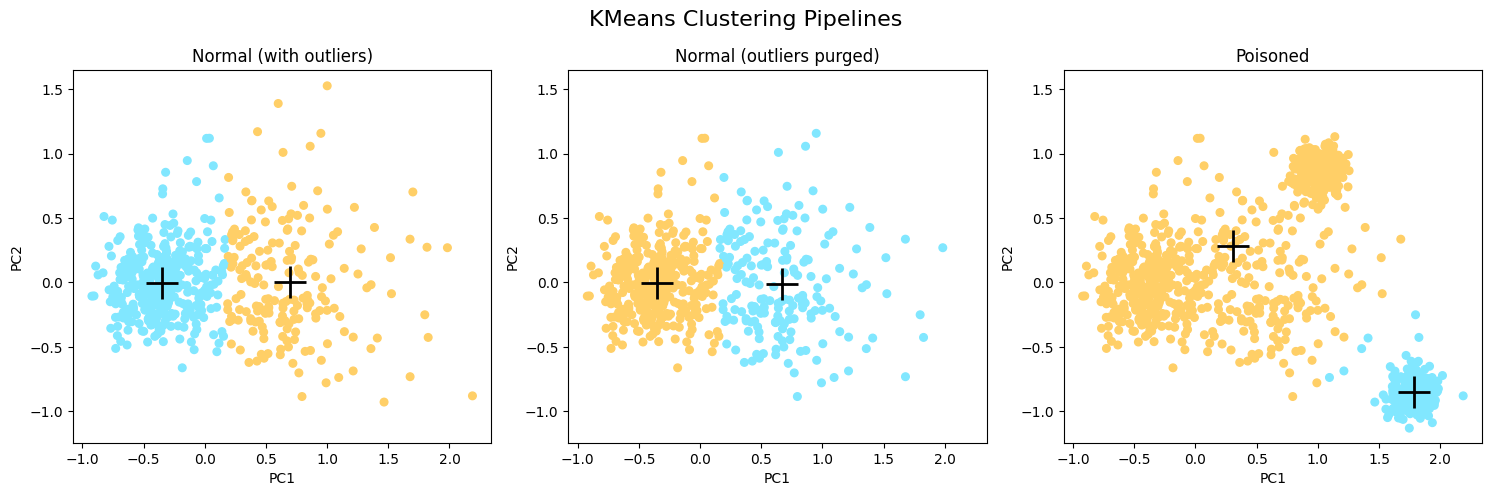

In [54]:
plot_effect_of_pipeline(
    pd.DataFrame(normPipelineNoPurge.x), normPipelineNoPurge.centroids, normPipelineNoPurge.clustering_labels,
    pd.DataFrame(normPipeline.x), normPipeline.centroids, normPipeline.clustering_labels,
    pd.DataFrame(poisPipeline.x), poisPipeline.centroids, poisPipeline.clustering_labels,
    titles=["KMeans Clustering Pipelines", "Normal (with outliers)", "Normal (outliers purged)", "Poisoned"])

In [55]:
score_table(pipelines=[normPipeline, poisPipeline],
            names=['Normal clustering', 'Poisoned clustering'])

,Normal clustering,Poisoned clustering
Silhouette score,0.3853,0.5130
Calinski-Harabasz Index,377.5418,1261.8382
Davies-Bouldin Index,1.1155,0.6937
Mean within-cluster std.,0.1071,0.1372


### Limitations

The attack relies on the outliers of the dataset. If there are no outliers in the dataset then there is nothing to be concealed. In this case, manual injection of outliers may take place during the attack to ensure its success.